In [2]:
# Function to read the static file
def read_static(static_file):
    with open(static_file, 'r') as f:
        num_particles = int(f.readline().strip())
        square_side_length = float(f.readline().strip())
        particles = []
        for _ in range(num_particles):
            radius, prop = map(float, f.readline().strip().split())
            particles.append({'radius': radius, 'prop': prop})
    return square_side_length, particles

# Function to read the dynamic file
def read_dynamic(dynamic_file):
    with open(dynamic_file, 'r') as f:
        positions = []
        f.readline()  # skip first line
        for line in f:
            x, y = map(float, line.strip().split()[:2])
            positions.append({'x': x, 'y': y})
    return positions

# Function to read the output file
def read_output(output_file):
    with open(output_file, 'r') as f:
        execution_time = float(f.readline().strip())  # read exec time
        neighbors = {}
        for line in f:
            parts = line.strip().split('\t', 1)
            index = int(parts[0])
            if len(parts) == 2 and parts[1]:
                neighbor_list = parts[1]
                neighbors[index] = list(map(int, neighbor_list.split(', ')))
            else:
                neighbors[index] = []
    return execution_time, neighbors

static_file = "particles_static.txt"
dynamic_file = "particles_dynamic.txt"
output_file = "out.txt"

In [ ]:
square_side_length, particles = read_static(static_file)
positions = read_dynamic(dynamic_file)
execution_time, neighbors = read_output(output_file)

In [ ]:
square_side_length, particles, positions, execution_time, neighbors

In [ ]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_path, geom_text, theme, element_text, labs, scale_size, \
    scale_color_manual, coord_fixed
import numpy as np

def plot_particle_with_neighbors(positions, particles, neighbors, particle_id, rc=0):
    data = pd.DataFrame({
        'x': [pos['x'] for pos in positions],
        'y': [pos['y'] for pos in positions],
        'size': [particle['radius'] for particle in particles],
        'color': ['blue'] * len(positions),
    })
    data['index'] = data.index.astype(str)

    # Set colors for selected particle and its neighbors
    data.at[particle_id, 'color'] = 'green'
    for neighbor_id in neighbors.get(particle_id, []):
        data.at[neighbor_id, 'color'] = 'red'

    selected_particle = data.loc[particle_id]
    rc_i = rc + particles[particle_id]['radius']
    circle_alpha = 1 if rc > 0 else 0
    circle = pd.DataFrame({
        'x': selected_particle['x'] + rc_i * np.cos(np.linspace(0, 2 * np.pi, 100)),
        'y': selected_particle['y'] + rc_i * np.sin(np.linspace(0, 2 * np.pi, 100))
    })

    p = (ggplot(data, aes(x='x', y='y'))
         + geom_point(aes(size='size', color='color'), alpha=0.6, stroke=1)
         + geom_text(aes(label='index'), nudge_y=0.1, size=8, color='black')
         + geom_path(aes(x='x', y='y'), data=circle, color='#fdc086', alpha=circle_alpha, size=1)
         + scale_color_manual(values={'blue': 'blue', 'red': 'red', 'green': 'green'})
         + labs(title=f"Particle {particle_id} and its Neighbors", x="X Position", y="Y Position")
         + theme(legend_position='none',
                 plot_title=element_text(size=15, face='bold'),
                 axis_title_x=element_text(size=12),
                 axis_title_y=element_text(size=12))
        + coord_fixed()
        )

    p.show()

plot_particle_with_neighbors(positions, particles, neighbors, 13, 1)


In [11]:
import os
from pprint import pprint

def generate_input_files(N, L, r):
    os.system(f"python generate_random_input.py --N {N} --L {L} --radius {r}")

def compute_cim(rc, m, periodic):
    os.system(f"python main.py --static_file particles_static.txt --dynamic_file particles_dynamic.txt --rc {rc} --m {m} --brute_force False --periodic_boundaries {periodic}")
    execution_time_cim, neighbors_cim = read_output(output_file)
    return execution_time_cim

def compute_bf(rc, periodic):
    os.system(f"python main.py --static_file particles_static.txt --dynamic_file particles_dynamic.txt --rc {rc} --brute_force True --periodic_boundaries {periodic}")
    execution_time_bf, neighbors_bf = read_output(output_file)
    return execution_time_bf

def test():
    L = 20
    rc = 1
    r = 0.25
    periodic = True
    N_values = [5000, 10000]
    M_values = [3, 5, 8, 13]

    cim_times = []
    bf_times = []

    result_data = []

    for N in N_values:
        generate_input_files(N, L, r)

        for m in M_values:
            cim_time = compute_cim(rc, m, periodic)
            cim_times.append(cim_time)
            result_data.append({ 'Method': 'CIM', 'N': N, 'M': m, 'Time': cim_time})

        bf_time = compute_bf(rc, periodic)
        bf_times.append(bf_time)
        result_data.append({ 'Method': 'BF', 'N': N, 'M': 0, 'Time': bf_time})


    return result_data

result = test()
pprint(result)

Execution time: 3.955265 seconds
Execution time: 2.264141 seconds
Execution time: 0.971034 seconds
Execution time: 0.472321 seconds
Execution time: 0.223622 seconds
Execution time: 3.010598 seconds
Execution time: 15.736385 seconds
Execution time: 9.111473 seconds
Execution time: 4.314100 seconds
Execution time: 1.950383 seconds
Execution time: 0.935047 seconds
Execution time: 11.666259 seconds
[{'M': 2, 'Method': 'CIM', 'N': 5000, 'Time': 3.955265},
 {'M': 3, 'Method': 'CIM', 'N': 5000, 'Time': 2.264141},
 {'M': 5, 'Method': 'CIM', 'N': 5000, 'Time': 0.971034},
 {'M': 8, 'Method': 'CIM', 'N': 5000, 'Time': 0.472321},
 {'M': 13, 'Method': 'CIM', 'N': 5000, 'Time': 0.223622},
 {'M': 0, 'Method': 'BF', 'N': 5000, 'Time': 3.010598},
 {'M': 2, 'Method': 'CIM', 'N': 10000, 'Time': 15.736385},
 {'M': 3, 'Method': 'CIM', 'N': 10000, 'Time': 9.111473},
 {'M': 5, 'Method': 'CIM', 'N': 10000, 'Time': 4.3141},
 {'M': 8, 'Method': 'CIM', 'N': 10000, 'Time': 1.950383},
 {'M': 13, 'Method': 'CIM', '

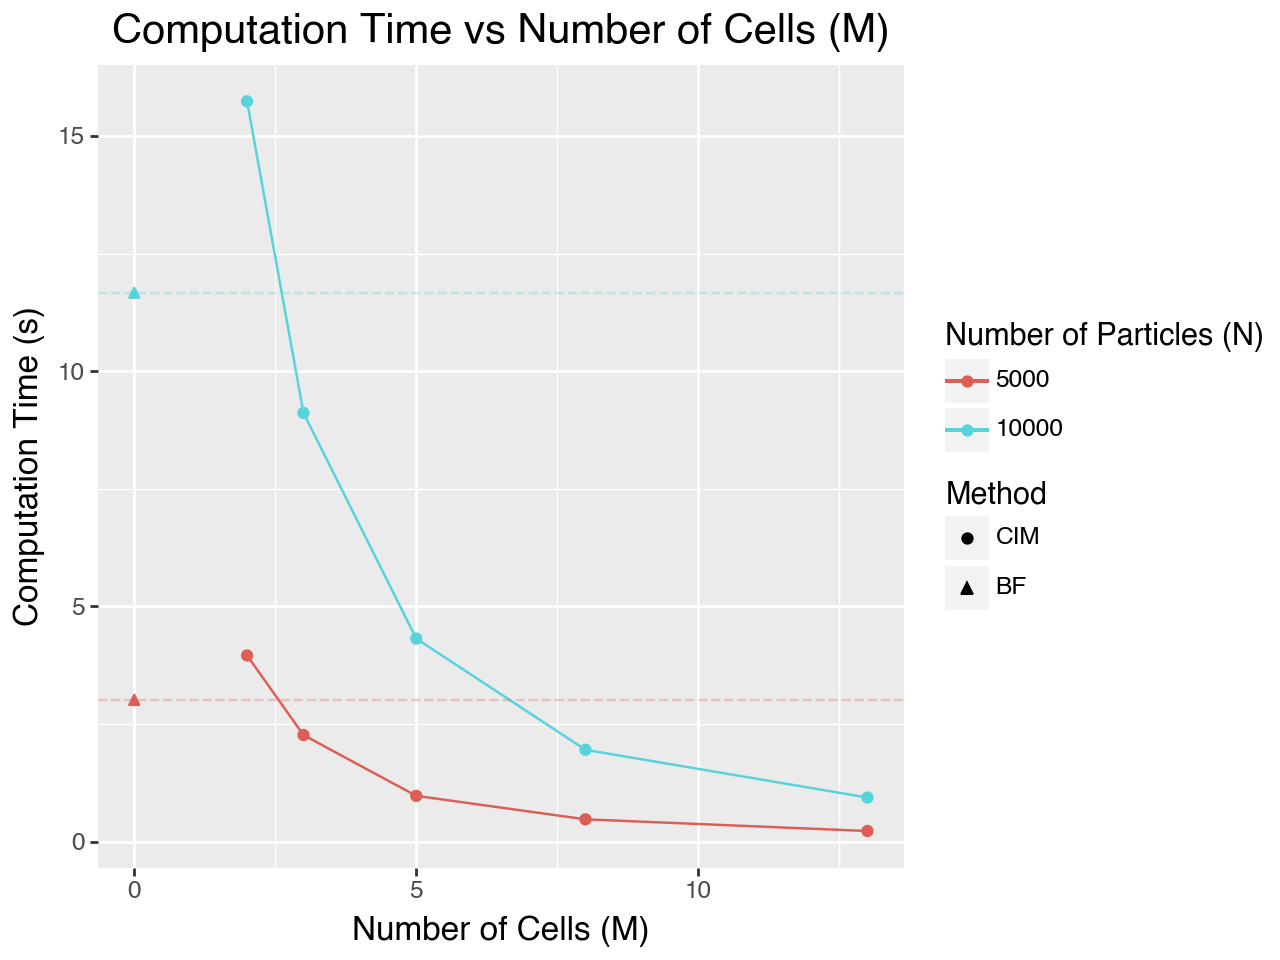

In [12]:
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, geom_hline, labs, theme, element_text, scale_color_discrete

df = pd.DataFrame(result)
bf_data = df[df['Method'] == 'BF']
cim_data = df[df['Method'] == 'CIM']

p = (ggplot(df, aes(x='M', y='Time', color='factor(N)', shape='Method'))
     + geom_line(data=cim_data)
     + geom_point()
     + geom_hline(aes(yintercept='Time', color='factor(N)'), data=bf_data, linetype='dashed', alpha=0.3)
     + labs(title='Computation Time vs Number of Cells (M)',
            x='Number of Cells (M)',
            y='Computation Time (s)',
            color='Number of Particles (N)')
     + theme(plot_title=element_text(size=15, face='bold'),
             axis_title_x=element_text(size=12),
             axis_title_y=element_text(size=12))
     + scale_color_discrete(name='Number of Particles (N)')
    )

p.show()